# Preprocessing 20210915
Having reached something of a plateau wrt architecture and model composition, I want to try and revist my preprocessing steps. Ideas (partly drawn from forum discussion threads):

1. Add more summary statistic features (as described [here](https://www.kaggle.com/c/tabular-playground-series-sep-2021/discussion/270899)
2. Try to get `PolynomialFeatures` working with `interaction_only=True`
3. Try methods of feature selection
4. Try some form of processing for likely categorical features (perhaps an embedding?)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
import wandb
from wandb.xgboost import wandb_callback
# import timm
from pathlib import Path
import os
import math
import seaborn as sns
from datetime import datetime

# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from joblib import dump, load
from sklearn.impute import SimpleImputer, KNNImputer
# feature engineering tools
# from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft
import missingno as msno
from sklearn.decomposition import PCA, IncrementalPCA

In [2]:
%matplotlib inline
%config Completer.use_jedi = False
os.environ['WANDB_NOTEBOOK_NAME'] = f"preprocessing_{datetime.now().strftime('%Y%m%d')}.ipynb"
# config = {
#     # model config
#     "model":None,
#     "tree_method": "auto", # set to 'gpu_hist' to try GPU if available
#     "booster": 'dart', # dart may be marginally better, but will opt for this quicker approach as a default
#     "n_estimators": 400, 
#     "max_depth": 3,
#     "learning_rate": 0.1522,
#     "test_size": 0.2,
#     "scaler": MaxAbsScaler,
# #     "task_type": "GPU", # for CatBoost only
# #     "reg_alpha": 2.8,
# #     "reg_lambda": 3.987,
# #     "feature_selector": SelectKBest,
# #     "k_best": 80,
# #     "feature_selection_scoring": f_regression,
#     'random_state': 42,
#     'subsample': 1,
#     'n_jobs': -1,
#     'verbosity': 1,
#     'k_folds': 5,
#     'features_created': False,
#     'feature_creator': None,
# }

# config_run = {
#     # wandb config:
#     'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
#     'tags': ['XGBoost', 'kfold', 'scaling'],
#     'notes': "A straight-up replication of previous best mdoel -- a 400 estimator Dart-boosted one -- with k-fold ensembling. No feature generation or selection.",
# }

In [3]:
datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/')

In [4]:
# df = pd.read_csv(datapath/'train.csv', index_col='id', low_memory=False)
# df.index.name = None
# df.to_feather(path='./dataset_df.feather')

In [5]:
# load unaltered dataset
df = pd.read_feather(path='dataset_df.feather')
df.index.name = 'id'

In [6]:
df.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       ...
       'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118',
       'claim'],
      dtype='object', length=119)

So 119 features this time, with the dependent variable being `'claim'`.

In [7]:
y = df.claim

In [8]:
features = [x for x in df.columns if x != 'claim']
X = df[features]

# Adding a NaN feature

In [9]:
row_nans = X.isnull().sum(axis=1)

In [10]:
row_nans

id
0         1
1         0
2         5
3         2
4         8
         ..
957914    0
957915    4
957916    0
957917    1
957918    4
Length: 957919, dtype: int64

In [11]:
X_new = X.copy()

In [12]:
X.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       ...
       'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117',
       'f118'],
      dtype='object', length=118)

In [13]:
X_new['nan_count'] = row_nans

# Adding (Other) Summary Statistics

In [14]:
X_new['num_missing_std'] = X.isna().std(axis=1).astype('float')

In [15]:
X_new['mean'] = X.mean(axis=1)

In [16]:
X_new['median'] = X.median(axis=1)

In [17]:
X_new['std'] = X.std(axis=1)

In [18]:
X_new['mad'] = X.mad(axis=1)

In [19]:
X_new['var'] = X.var(axis=1)

In [20]:
X_new['skew'] = X.skew(axis=1)

In [21]:
X_new['max'] = X.abs().max(axis=1)

In [22]:
X_new['min'] = X.abs().min(axis=1)

In [23]:
len(X_new.columns)

128

In [24]:
X_new.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,nan_count,num_missing_std,mean,median,std,mad,var,skew,max,min
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,1,0.092057,1.106623e+14,5.93250,1.012911e+15,2.137080e+14,1.025988e+30,10.622563,1.090600e+16,0.000276
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,0,0.000000,3.881173e+14,4.98505,2.945630e+15,7.490904e+14,8.676734e+30,9.711352,3.079400e+16,0.000204
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,5,0.202297,3.139781e+12,3.57530,3.105740e+13,6.816492e+12,9.645622e+26,9.836786,3.218100e+14,0.000455
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,2,0.129631,1.672354e+13,2.94925,1.763090e+14,3.401685e+13,3.108486e+28,10.690529,1.894700e+15,0.000007
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,8,0.252469,1.148054e+14,5.49490,9.816106e+14,2.228564e+14,9.635593e+29,9.965738,1.012500e+16,0.000344


# PCA

In [25]:
# missing values must be imputed first
imputer = SimpleImputer(add_indicator=True, strategy='median')
X_imputed_np = imputer.fit_transform(X_new)

In [29]:
X_imputed = pd.DataFrame(X_imputed_np, columns=[str(x) for x in range(X_imputed_np.shape[1])])

In [30]:
X_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
X_imputed.to_feather(path=datapath/'X_NaNcounts_SummaryStats_imputed-Median-wIndicators.feather')

In [32]:
scaler = StandardScaler()
X_imputed_scaled_np = scaler.fit_transform(X_imputed)

In [33]:
X_imputed_scaled = pd.DataFrame(X_imputed_scaled_np, columns=[str(x) for x in range(len(X_imputed.columns))])

In [34]:
X_imputed_scaled.to_feather(path=datapath/'X_NaNcounts_SummaryStats_imputed-Median-wIndicators-StandardScaled.feather')

In [15]:
# pca = PCA(n_components='mle', random_state=42)
# pca.fit(X_imputed_scaled)

In [16]:
# print(pca.explained_variance_ratio_)

In [17]:
# print(pca.singular_values_)

In [18]:
# X_pca_np = pca.fit_transform(X_imputed_scaled)

In [19]:
# X_pca_np.shape

So, using Minka's MLE for the PCA eliminates a single feature -- not so helpful.

In [20]:
# pca_eighty = PCA(n_components=0.8, random_state=42)
# X_pca_eighty = pca_eighty.fit_transform(X_imputed_scaled)

In [21]:
# X_pca_eighty.shape # 94 features

In [22]:
# pca_seventy = PCA(n_components=0.7, random_state=42)
# X_pca_seventy = pca_seventy.fit_transform(X_imputed_scaled)

In [23]:
# X_pca_seventy.shape # 82 features

In [24]:
# pca_full = PCA(n_components=None, random_state=42)
# pca_full.fit(X_imputed_scaled)

In [25]:
# sns.lineplot(data=np.cumsum(pca_full.explained_variance_ratio_)) # basically a slope-1 line

So, it would indeed seem that there's not much point in doing dimensionality reduction on the original (scaled, SimplyImputed) dataset. But, perhaps PCA would come in handy after feature generation?

# Feature Generation

In [26]:
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# X_imputed_scaled_poly_np = poly.fit_transform(X_imputed_scaled)
# dump(X_imputed_scaled_poly_np, datapath/'X_SimpleImputed_StandardScaled_PolyDeg2wInteract_np.joblib')
X_imputed_scaled_poly_np = load(datapath/'X_SimpleImputed_StandardScaled_PolyDeg2wInteract_np.joblib')

In [27]:
X_imputed_scaled_poly_np.shape

(957919, 7139)

In [28]:
# dump(X_imputed_scaled_poly_np, datapath/'X_SimpleImputed_StandardScaled_PolyDeg2wInteract_np.joblib')

In [29]:
# See note in [[sklearn.decomposition.IncrementalPCA]] about how I worked around memory limits
# pca = IncrementalPCA(n_components=None)
# X_imputed_scaled_poly_pca = pca.fit(X_imputed_scaled_poly_np)

In [30]:
pca_ratios = load(datapath/'pca-full_ratios_20210906.joblib')

<AxesSubplot:>

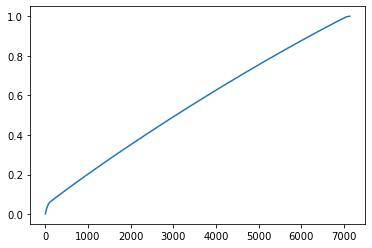

In [31]:
sns.lineplot(data=np.cumsum(pca_ratios))

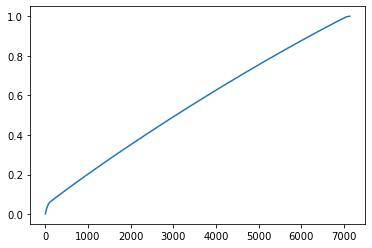

In [33]:
fig = sns.lineplot(data=np.cumsum(pca_ratios)).get_figure()

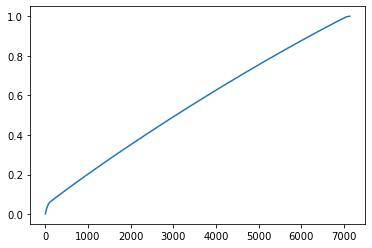

In [34]:
fig

In [36]:
fig.savefig(fname=datapath/'pca_elbow_plot_20210906a.png')

In [32]:
pca_ratios

array([1.69885593e-03, 1.53315565e-03, 1.36297211e-03, ...,
       5.64593436e-06, 5.49194323e-06, 1.99843187e-06])

# General

In [12]:
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [13]:
len(X)

957919

- So there are more datapoints this time around than in August (where there were just 250000)

In [64]:
X.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
count,942672.000000,942729.000000,942428.000000,942359.000000,942514.000000,942398.000000,942415.000000,9.425460e+05,9.426700e+05,942696.000000,...,942390.000000,942554.000000,942420.000000,942509.000000,942686.000000,942481.000000,942360.000000,9.423300e+05,942512.000000,942707.000000
mean,0.090201,0.345964,4068.744207,0.201214,0.304869,-0.071458,1620.843815,3.771642e+05,1.806054e+15,5323.442367,...,0.398622,-19.926398,2.074530,23.885245,1.748777,63152.973540,1.208876,4.276905e+16,3959.204669,0.559267
std,0.043564,0.146251,6415.829440,0.212510,0.145343,2.123777,1276.281403,3.454325e+05,2.335204e+15,10068.380032,...,0.298071,18.578439,0.895793,45.581360,10.088848,92435.016241,0.114959,6.732441e+16,3155.991777,0.408426
min,-0.149910,-0.019044,-9421.700000,-0.082122,-0.006990,-12.791000,-224.800000,-2.984300e+04,-1.153300e+15,-26404.000000,...,-0.042355,-105.860000,0.277040,-27.691000,-26.589000,-81977.000000,0.905270,-8.944400e+15,-415.240000,-0.151240
25%,0.070227,0.283050,418.430000,0.035086,0.240520,-1.120700,481.545000,9.120900e+04,1.153100e+13,75.876750,...,0.113780,-28.812000,1.487700,-0.628880,-4.473975,2443.200000,1.146800,2.321100e+14,1306.200000,0.276560
50%,0.090135,0.389100,1279.500000,0.137000,0.327790,-0.380110,1446.100000,2.896700e+05,5.043050e+14,1073.200000,...,0.359220,-14.636000,1.662100,1.727700,0.885710,19479.000000,1.177200,1.327500e+16,3228.000000,0.473440
75%,0.116500,0.458450,4444.400000,0.297100,0.412830,0.921940,2495.900000,5.605600e+05,3.103100e+15,5693.200000,...,0.624280,-5.325300,2.522325,18.991000,6.840775,88488.000000,1.242000,5.278700e+16,6137.900000,0.746210
max,0.415170,0.518990,39544.000000,1.319900,0.554750,11.202000,5426.600000,1.913700e+06,1.042400e+16,85622.000000,...,1.123600,1.613400,4.565900,217.840000,47.757000,526050.000000,1.886700,3.249900e+17,13151.000000,2.743600


In [70]:
X.mean(axis=1).max(), X.mean(axis=1).min()

(3985044011896016.5, -166670740692639.2)

In [73]:
means = X.mean(axis=0).sort_values()
means

f110   -1.992640e+01
f49    -4.253975e-01
f58    -3.293131e-01
f6     -7.145838e-02
f34    -4.636165e-06
            ...     
f98     1.415684e+13
f73     7.964640e+14
f9      1.806054e+15
f35     2.782318e+16
f116    4.276905e+16
Length: 118, dtype: float64

In [75]:
mins = X.min(axis=0).sort_values()
mins

f35    -2.068900e+16
f116   -8.944400e+15
f9     -1.153300e+15
f73    -2.802800e+14
f98    -5.714600e+12
            ...     
f115    9.052700e-01
f81     9.642000e-01
f97     9.961000e-01
f48     1.056400e+00
f54     9.886800e+01
Length: 118, dtype: float64

In [76]:
X['f35'].max()

1.5905e+17

## Categoricals

Do we have any categorical variables?

<AxesSubplot:>

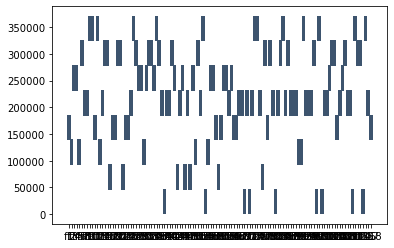

In [16]:
sns.histplot(x=X.columns, y=[len(X[f].unique()) for f in X.columns])    

- Here, `len(X[f].unique()) for f in X.columns` represents the number of unique values in each feature. We do have a fair amount of variance here, and it seems that there are quite a few repeated values (bearing in mind the dataset has a total of 957919 values).

In [22]:
low_cardinality_features = [{f: len(X[f].unique())} for f in X.columns if len(X[f].unique()) < 100000]
low_cardinality_features

[{'f17': 77995},
 {'f22': 83439},
 {'f38': 38268},
 {'f43': 81541},
 {'f46': 84045},
 {'f48': 87460},
 {'f54': 7460},
 {'f59': 76379},
 {'f69': 14050},
 {'f71': 30981},
 {'f76': 78698},
 {'f81': 33487},
 {'f97': 430},
 {'f99': 41906},
 {'f111': 44839},
 {'f115': 12971}]

In [23]:
higher_cardinality_features = [{f: len(X[f].unique())} for f in X.columns if len(X[f].unique()) > 100000]
higher_cardinality_features

[{'f1': 147966},
 {'f2': 117428},
 {'f3': 274625},
 {'f4': 265619},
 {'f5': 125415},
 {'f6': 286474},
 {'f7': 201976},
 {'f8': 209766},
 {'f9': 368026},
 {'f10': 370267},
 {'f11': 157266},
 {'f12': 325096},
 {'f13': 117374},
 {'f14': 231414},
 {'f15': 308573},
 {'f16': 313090},
 {'f18': 172560},
 {'f19': 160074},
 {'f20': 318318},
 {'f21': 313906},
 {'f23': 148461},
 {'f24': 176989},
 {'f25': 208330},
 {'f26': 333768},
 {'f27': 291000},
 {'f28': 269917},
 {'f29': 233936},
 {'f30': 135073},
 {'f31': 263379},
 {'f32': 297892},
 {'f33': 281104},
 {'f34': 245722},
 {'f35': 357009},
 {'f36': 316293},
 {'f37': 210949},
 {'f39': 229894},
 {'f40': 223438},
 {'f41': 307517},
 {'f42': 264544},
 {'f44': 213950},
 {'f45': 245352},
 {'f47': 212672},
 {'f49': 245197},
 {'f50': 127051},
 {'f51': 305729},
 {'f52': 212596},
 {'f53': 342518},
 {'f55': 117102},
 {'f56': 240291},
 {'f57': 246959},
 {'f58': 163485},
 {'f60': 158583},
 {'f61': 245797},
 {'f62': 266662},
 {'f63': 194154},
 {'f64': 267356},
 

Probably best of all to just list them all out.

In [32]:
cardinalities = pd.Series([len(X[f].unique()) for f in X.columns], index=X.columns).sort_values()
cardinalities

f97        430
f54       7460
f115     12971
f69      14050
f71      30981
         ...  
f35     357009
f73     357059
f92     362663
f9      368026
f10     370267
Length: 118, dtype: int64

- So f97 and f54 are the real outliers and best prospects for categorical variables, though I think there are plenty more. (And it's striking that the highest cardinality features still have only 1/3 the unique values as the number of values period.

## NaNs

In [33]:
df['f97'].head()

id
0    0.99662
1    0.99815
2        NaN
3    0.99898
4        NaN
Name: f97, dtype: float64

**Note** that we do have `NaN`s here. I wonder if that accounts for the lower-than-expected cardinalities.

In [34]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957919 entries, 0 to 957918
Data columns (total 119 columns):
 #    Column  Non-Null Count   Dtype  
---   ------  --------------   -----  
 0    f1      942672 non-null  float64
 1    f2      942729 non-null  float64
 2    f3      942428 non-null  float64
 3    f4      942359 non-null  float64
 4    f5      942514 non-null  float64
 5    f6      942398 non-null  float64
 6    f7      942415 non-null  float64
 7    f8      942546 non-null  float64
 8    f9      942670 non-null  float64
 9    f10     942696 non-null  float64
 10   f11     942494 non-null  float64
 11   f12     942326 non-null  float64
 12   f13     942455 non-null  float64
 13   f14     942697 non-null  float64
 14   f15     942410 non-null  float64
 15   f16     942475 non-null  float64
 16   f17     942492 non-null  float64
 17   f18     942594 non-null  float64
 18   f19     942445 non-null  float64
 19   f20     942464 non-null  float64
 20   f21     942465 non-null 

<ipython-input-34-6ac79f7ef903>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True, null_counts=True)


- So we have a lot of null values -- seemingly usually about 15k per feature (though almost never the precise same number). Are these null rows, plus a sprinkling of other missing bits, or are they smoothly distributed?

In [35]:
null_counts = pd.Series([X[f].isnull().sum() for f in X.columns])
null_counts

0      15247
1      15190
2      15491
3      15560
4      15405
       ...  
113    15438
114    15559
115    15589
116    15407
117    15212
Length: 118, dtype: int64

- So those are the number of `NaN`s by feature.

In [68]:
null_counts[95:98]

95    15285
96    15265
97    15288
dtype: int64

In [40]:
df.isna().any(axis=1).sum()

598455

- So there are a total of 598455 NaNs **ACTUALLY NOT SURE**

In [46]:
df.isna().any(axis=0)

f1        True
f2        True
f3        True
f4        True
f5        True
         ...  
f115      True
f116      True
f117      True
f118      True
claim    False
Length: 119, dtype: bool

In [45]:
df.isna().any(axis=0).sum()

118

- So all but one feature (namely, the target) has at least one NaN entry in it.

In [42]:
df[df.isna().any(axis=1)]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.108590,0.004314,-37.566,0.017364,0.289150,-10.25100,135.12,168900.00,3.992400e+14,86.489,...,-12.22800,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.10,1.017700,1
2,0.178030,-0.006980,907.270,0.272140,0.459480,0.17327,2298.00,360650.00,1.224500e+13,15827.000,...,-5.76880,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.20,0.406900,1
3,0.152360,0.007259,780.100,0.025179,0.519470,7.49140,112.51,259490.00,7.781400e+13,-36.837,...,-34.85800,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.10,0.514860,1
4,0.116230,0.502900,-109.150,0.297910,0.344900,-0.40932,2538.90,65332.00,1.907200e+15,144.120,...,-13.64100,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.230490,1
5,0.101530,-0.002612,-1118.700,0.116300,0.318860,-0.47839,2372.80,-1808.00,5.818100e+15,8421.200,...,-44.08200,3.5812,26.55900,-6.47220,44570.00,1.1776,2.997700e+14,5548.30,-0.033159,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957909,0.032316,NaN,2252.600,0.101450,0.267060,0.62894,369.94,99974.00,4.407500e+15,3397.500,...,-14.18500,1.4577,-0.65998,-4.27330,-284.32,1.4056,3.246600e+16,625.49,0.893300,1
957913,0.101450,0.421590,1562.000,0.029333,0.188490,-2.27280,3231.30,-227.35,2.744500e+14,18363.000,...,0.37221,1.6948,20.97300,-8.46590,-1482.60,1.1798,2.942500e+16,2984.70,0.319630,1
957915,0.134930,0.413600,1050.100,0.000521,-0.001246,1.76990,3519.90,862290.00,7.321400e+13,2869.000,...,-41.41800,2.6986,-1.09760,-1.09980,13826.00,1.3320,1.829400e+17,3300.50,0.929740,1


- The above table consists of all 598455 rows with at least one `NaN`

In [48]:
len(df[df.isna().any(axis=1)]) / len(df)

0.624744889703618

- So about 62% of the rows have at least one `NaN` in them. 

In [59]:
X.loc[:,:].isnull().all(axis=1).any()

False

- So this is saying that there are no rows where all the entries are NaNs (note I'm using `X` here rather than the full dataset).

In [63]:
df.isnull().sum(axis=1).sort_values()

id
383041     0
418652     0
418649     0
853360     0
418646     0
          ..
704655    14
559593    14
852751    14
877800    14
816024    14
Length: 957919, dtype: int64

- So there we go. No row has more than 14 features' (out of 118) values missing, meaning that the missing values are reasonably smoothly distributed throughout the dataset. So, we'll absolutely need to do imputation rather than simply trimming bad instances.

### `missingno`

In [84]:
X_sample = X.sample(250, random_state=42)

<AxesSubplot:>

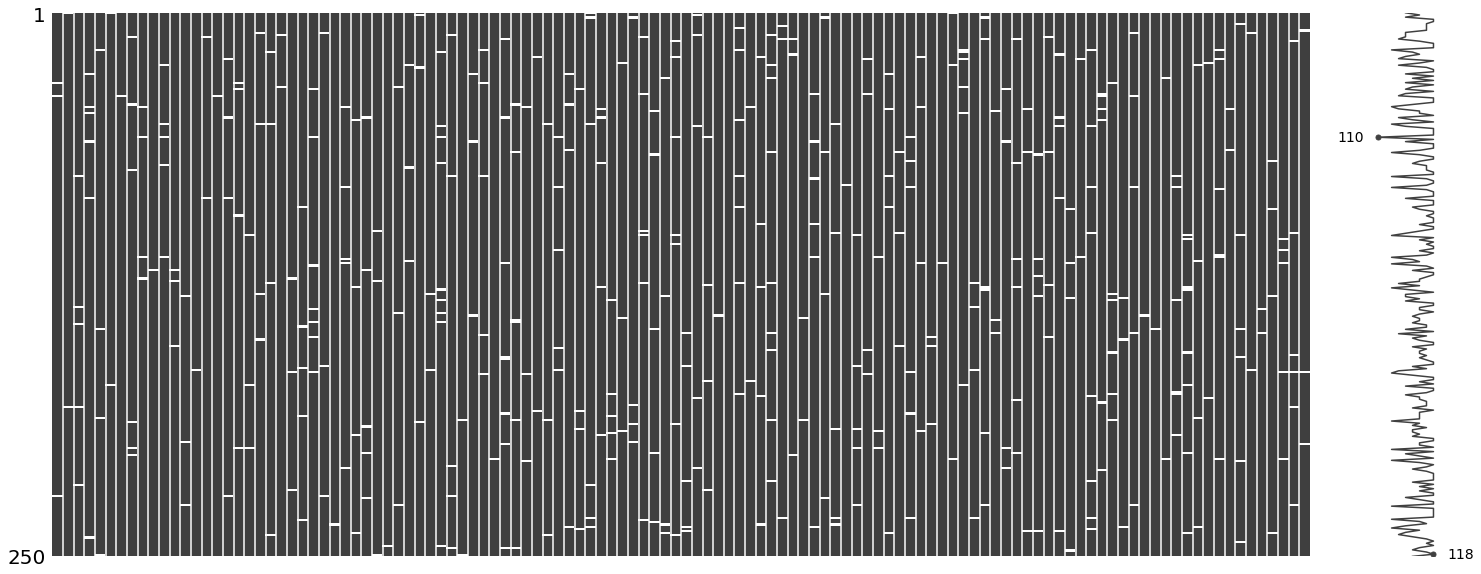

In [85]:
msno.matrix(X_sample)

In [87]:
X_sample['f110'].isna().sum()

6

In [88]:
X_sample['f118'].isna().sum()

3

In [89]:
max([X_sample[f].isna().sum() for f in X_sample.columns])

9

In [90]:
X_sample.iloc[110].isna().sum()

0

In [91]:
X_sample.iloc[118].isna().sum()

3

In [92]:
max([X_sample.iloc[x].isna().sum() for x in range(len(X_sample))])

8

- **Not sure precisely how to understand this**

In [93]:
X_sample_left = X_sample[:50]

<AxesSubplot:>

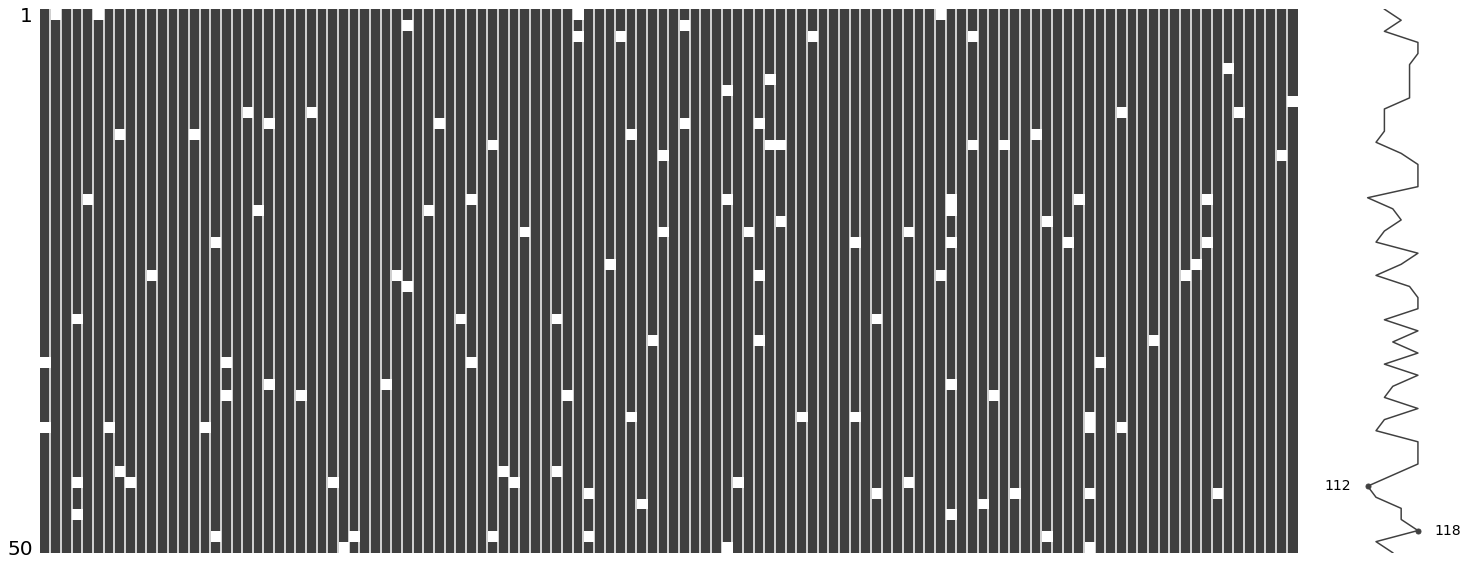

In [94]:
msno.matrix(X_sample_left)

<AxesSubplot:>

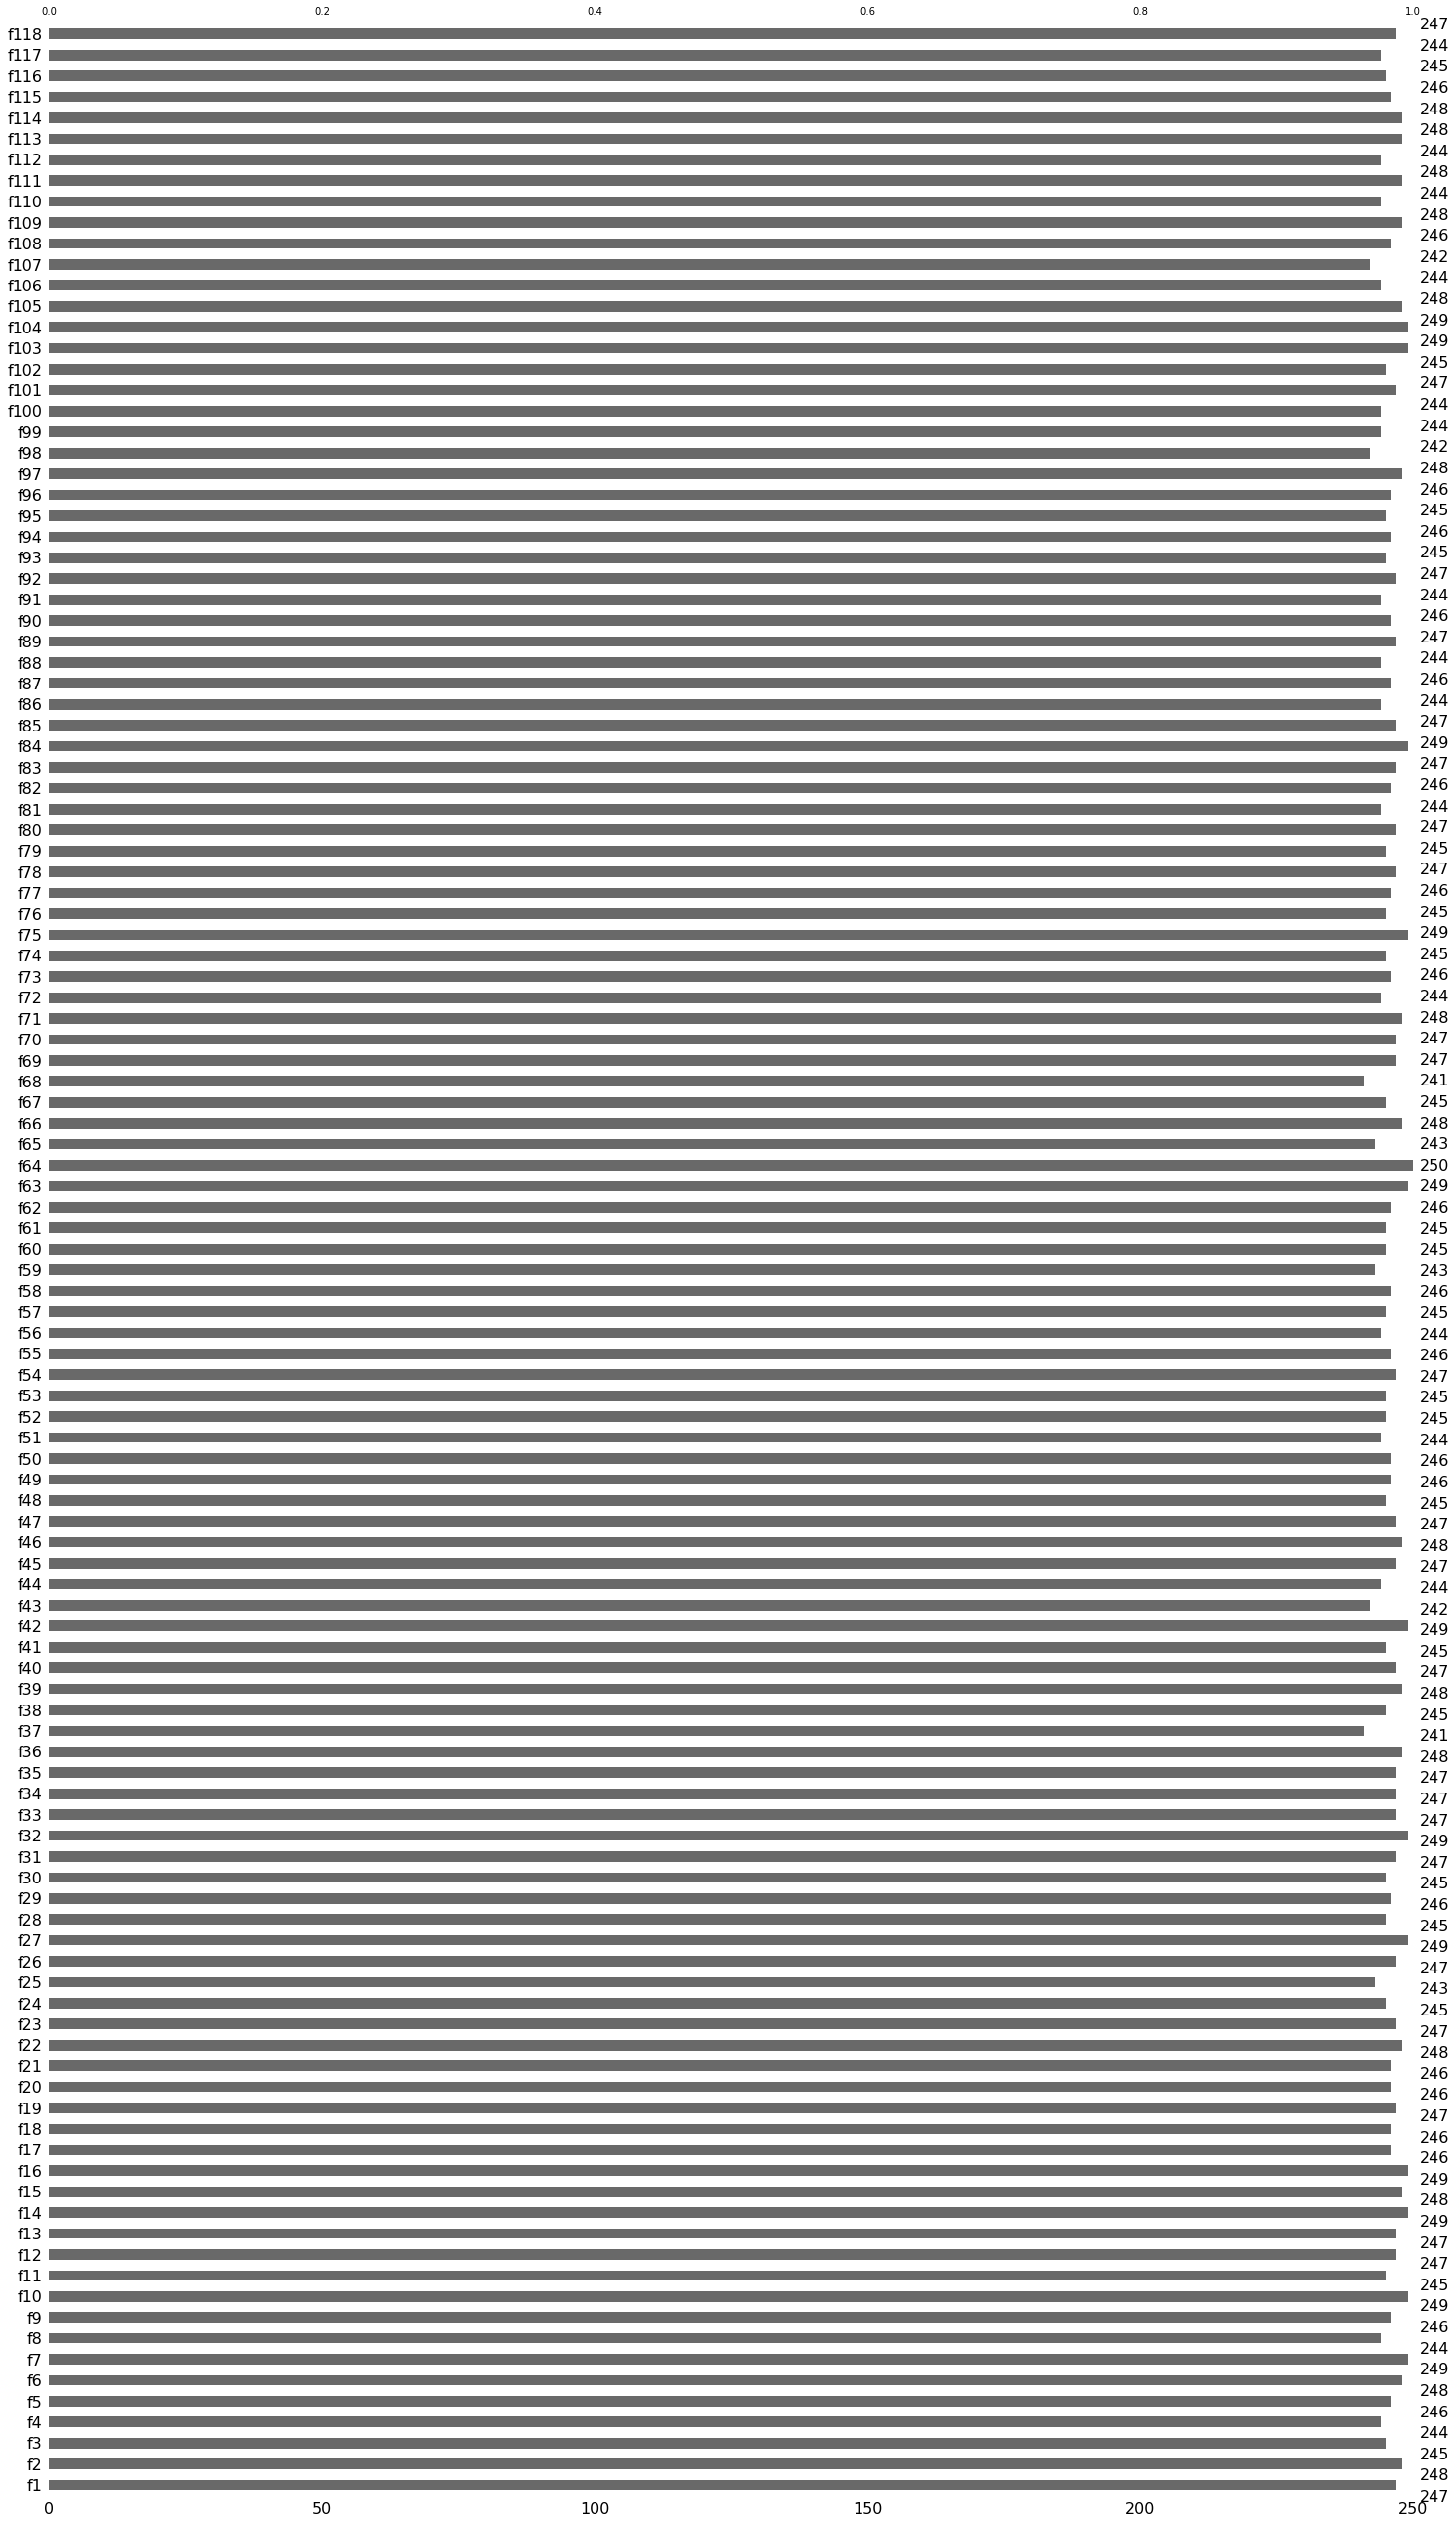

In [96]:
msno.bar(X_sample)

- That's more legible to me -- it's giving the features on the left and then on the right how many of the 250 sampled items have non-null values

<AxesSubplot:>

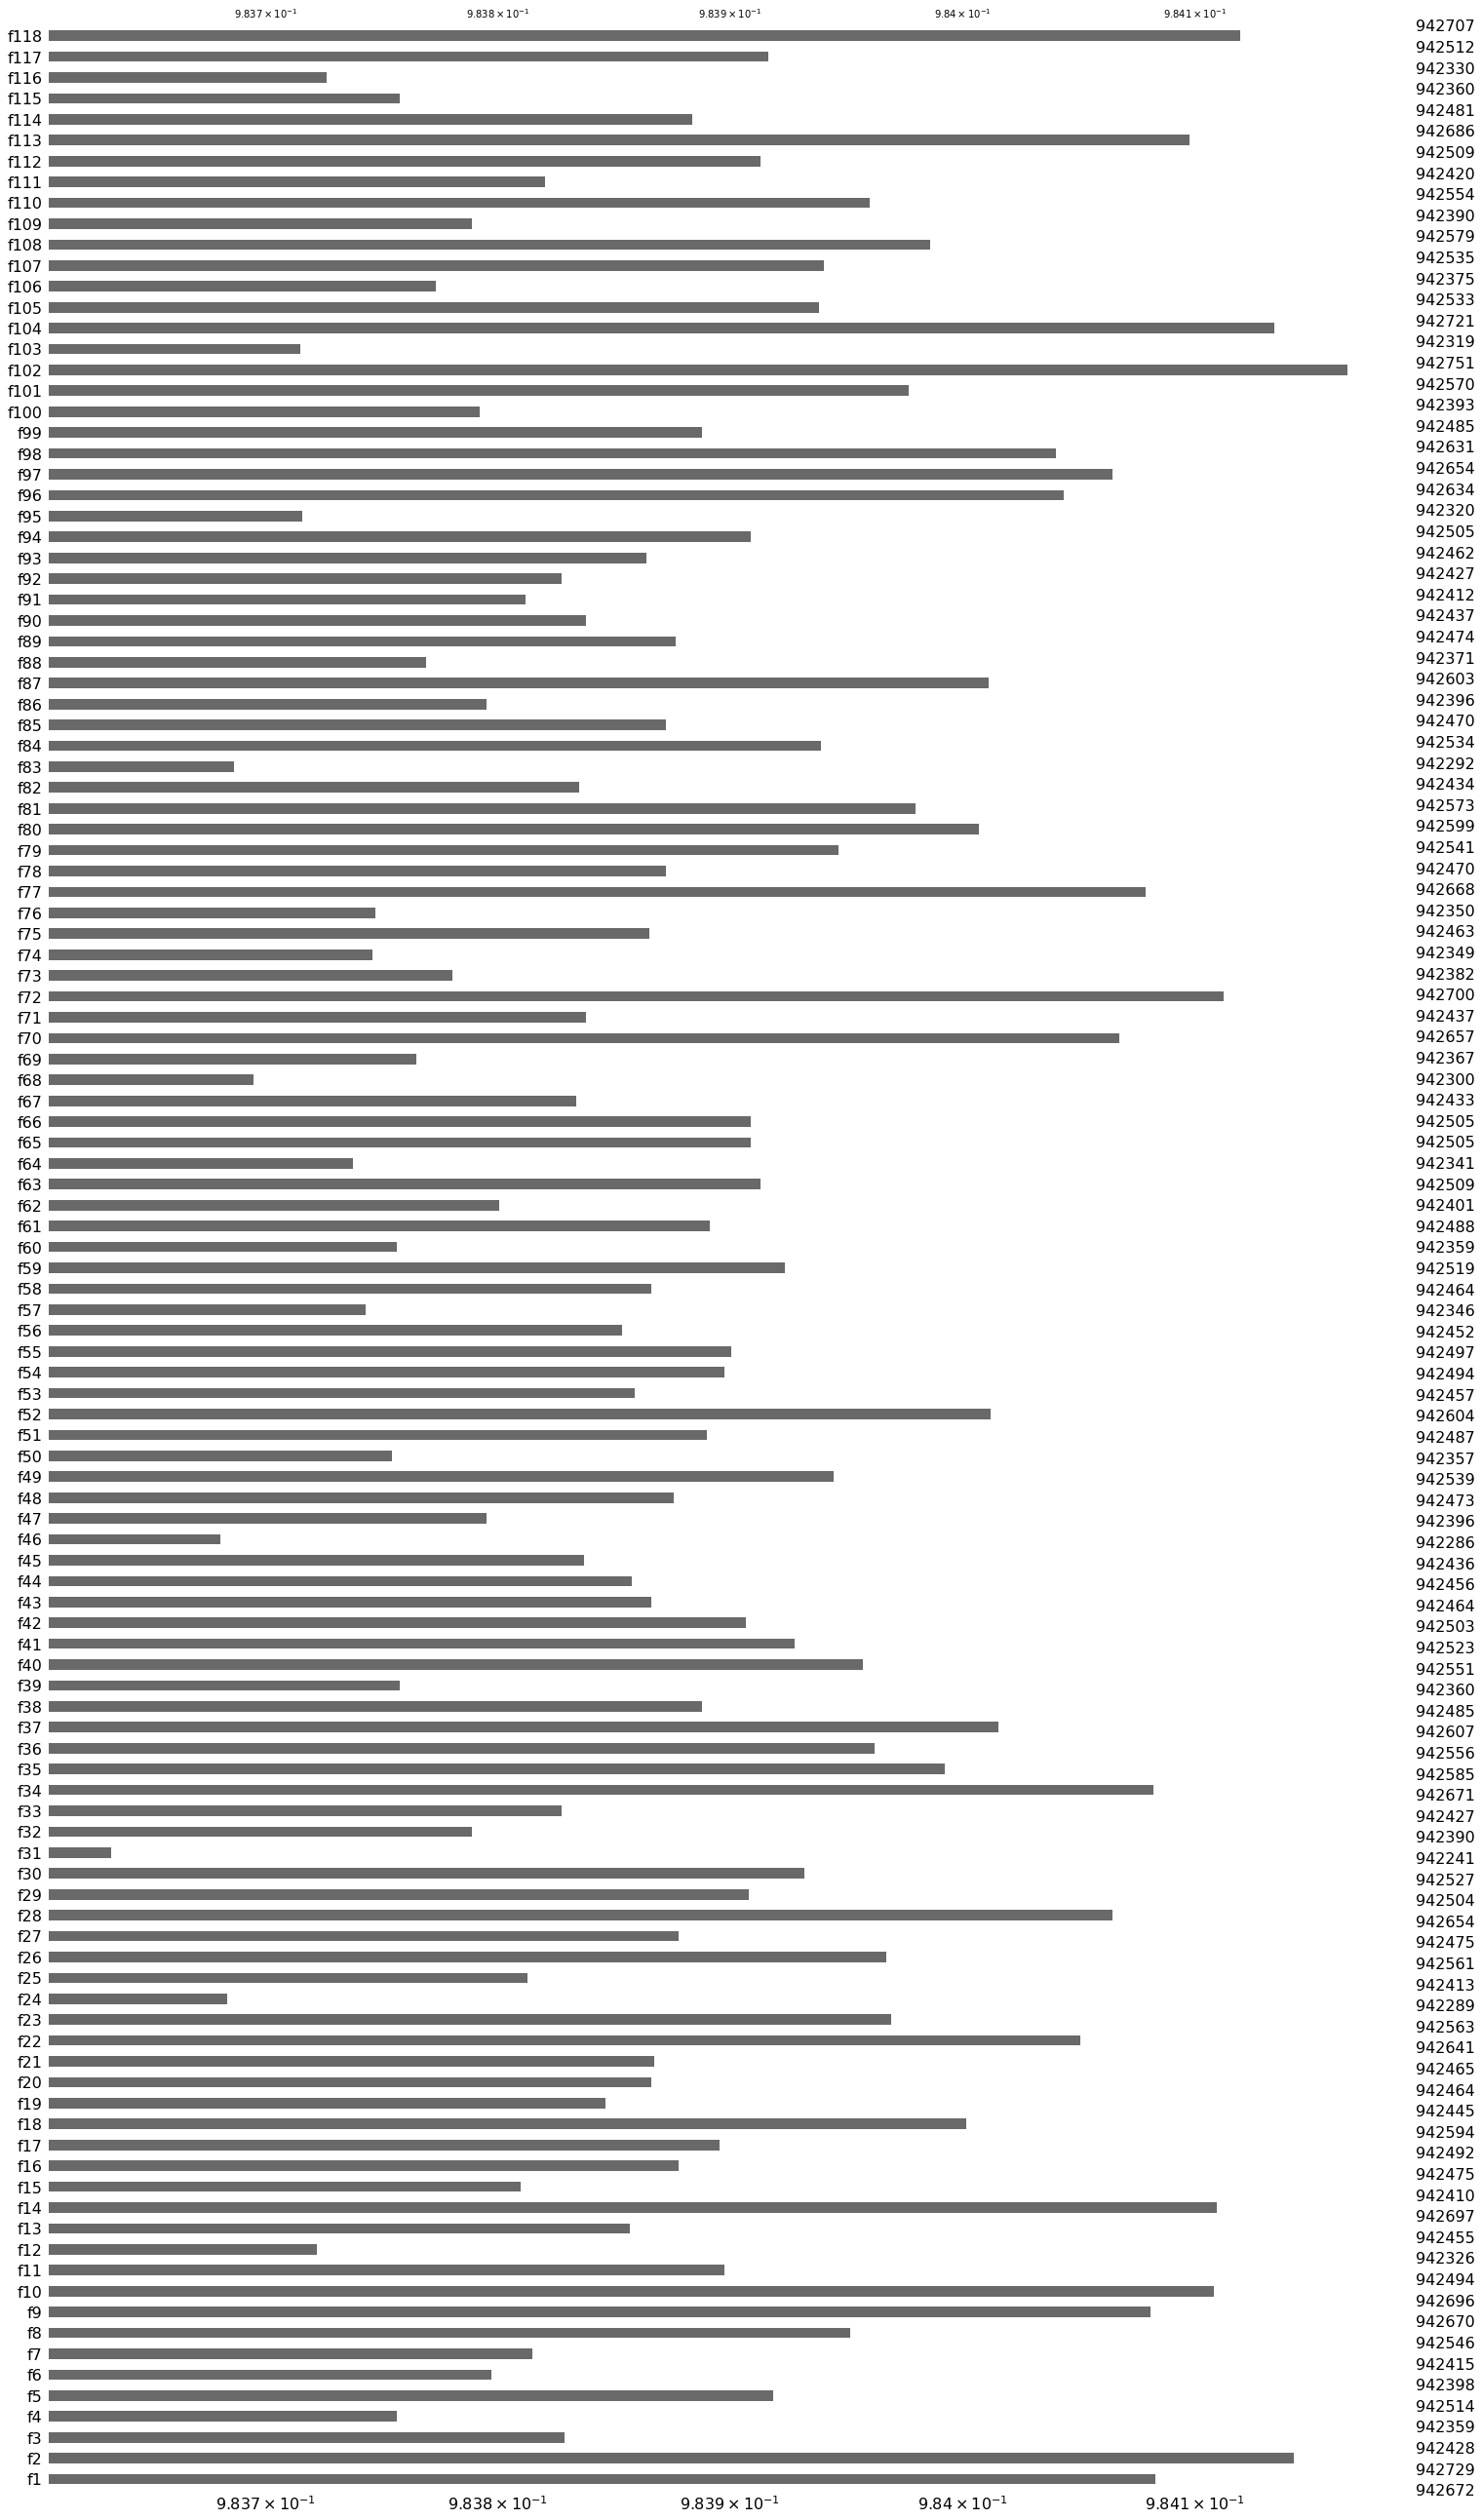

In [98]:
msno.bar(X, log=True)

- So, using the logarithmic scale, we can readily see that `f31` is the least complete feature. `f102` is the most complete.

<AxesSubplot:>

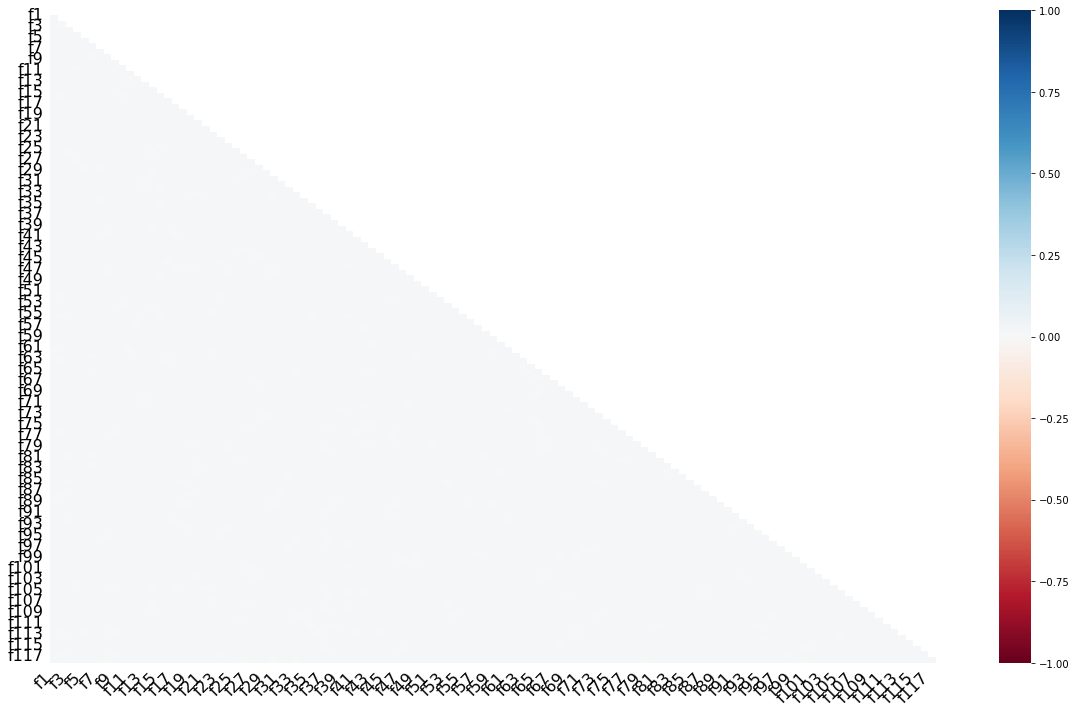

In [104]:
msno.heatmap(X)

- The absences do indeed seem to be independent of one another (and it's not just an artifact of the visualization -- you *can* see hot spots on very small subsamples, e.g. 50 rows)

<AxesSubplot:>

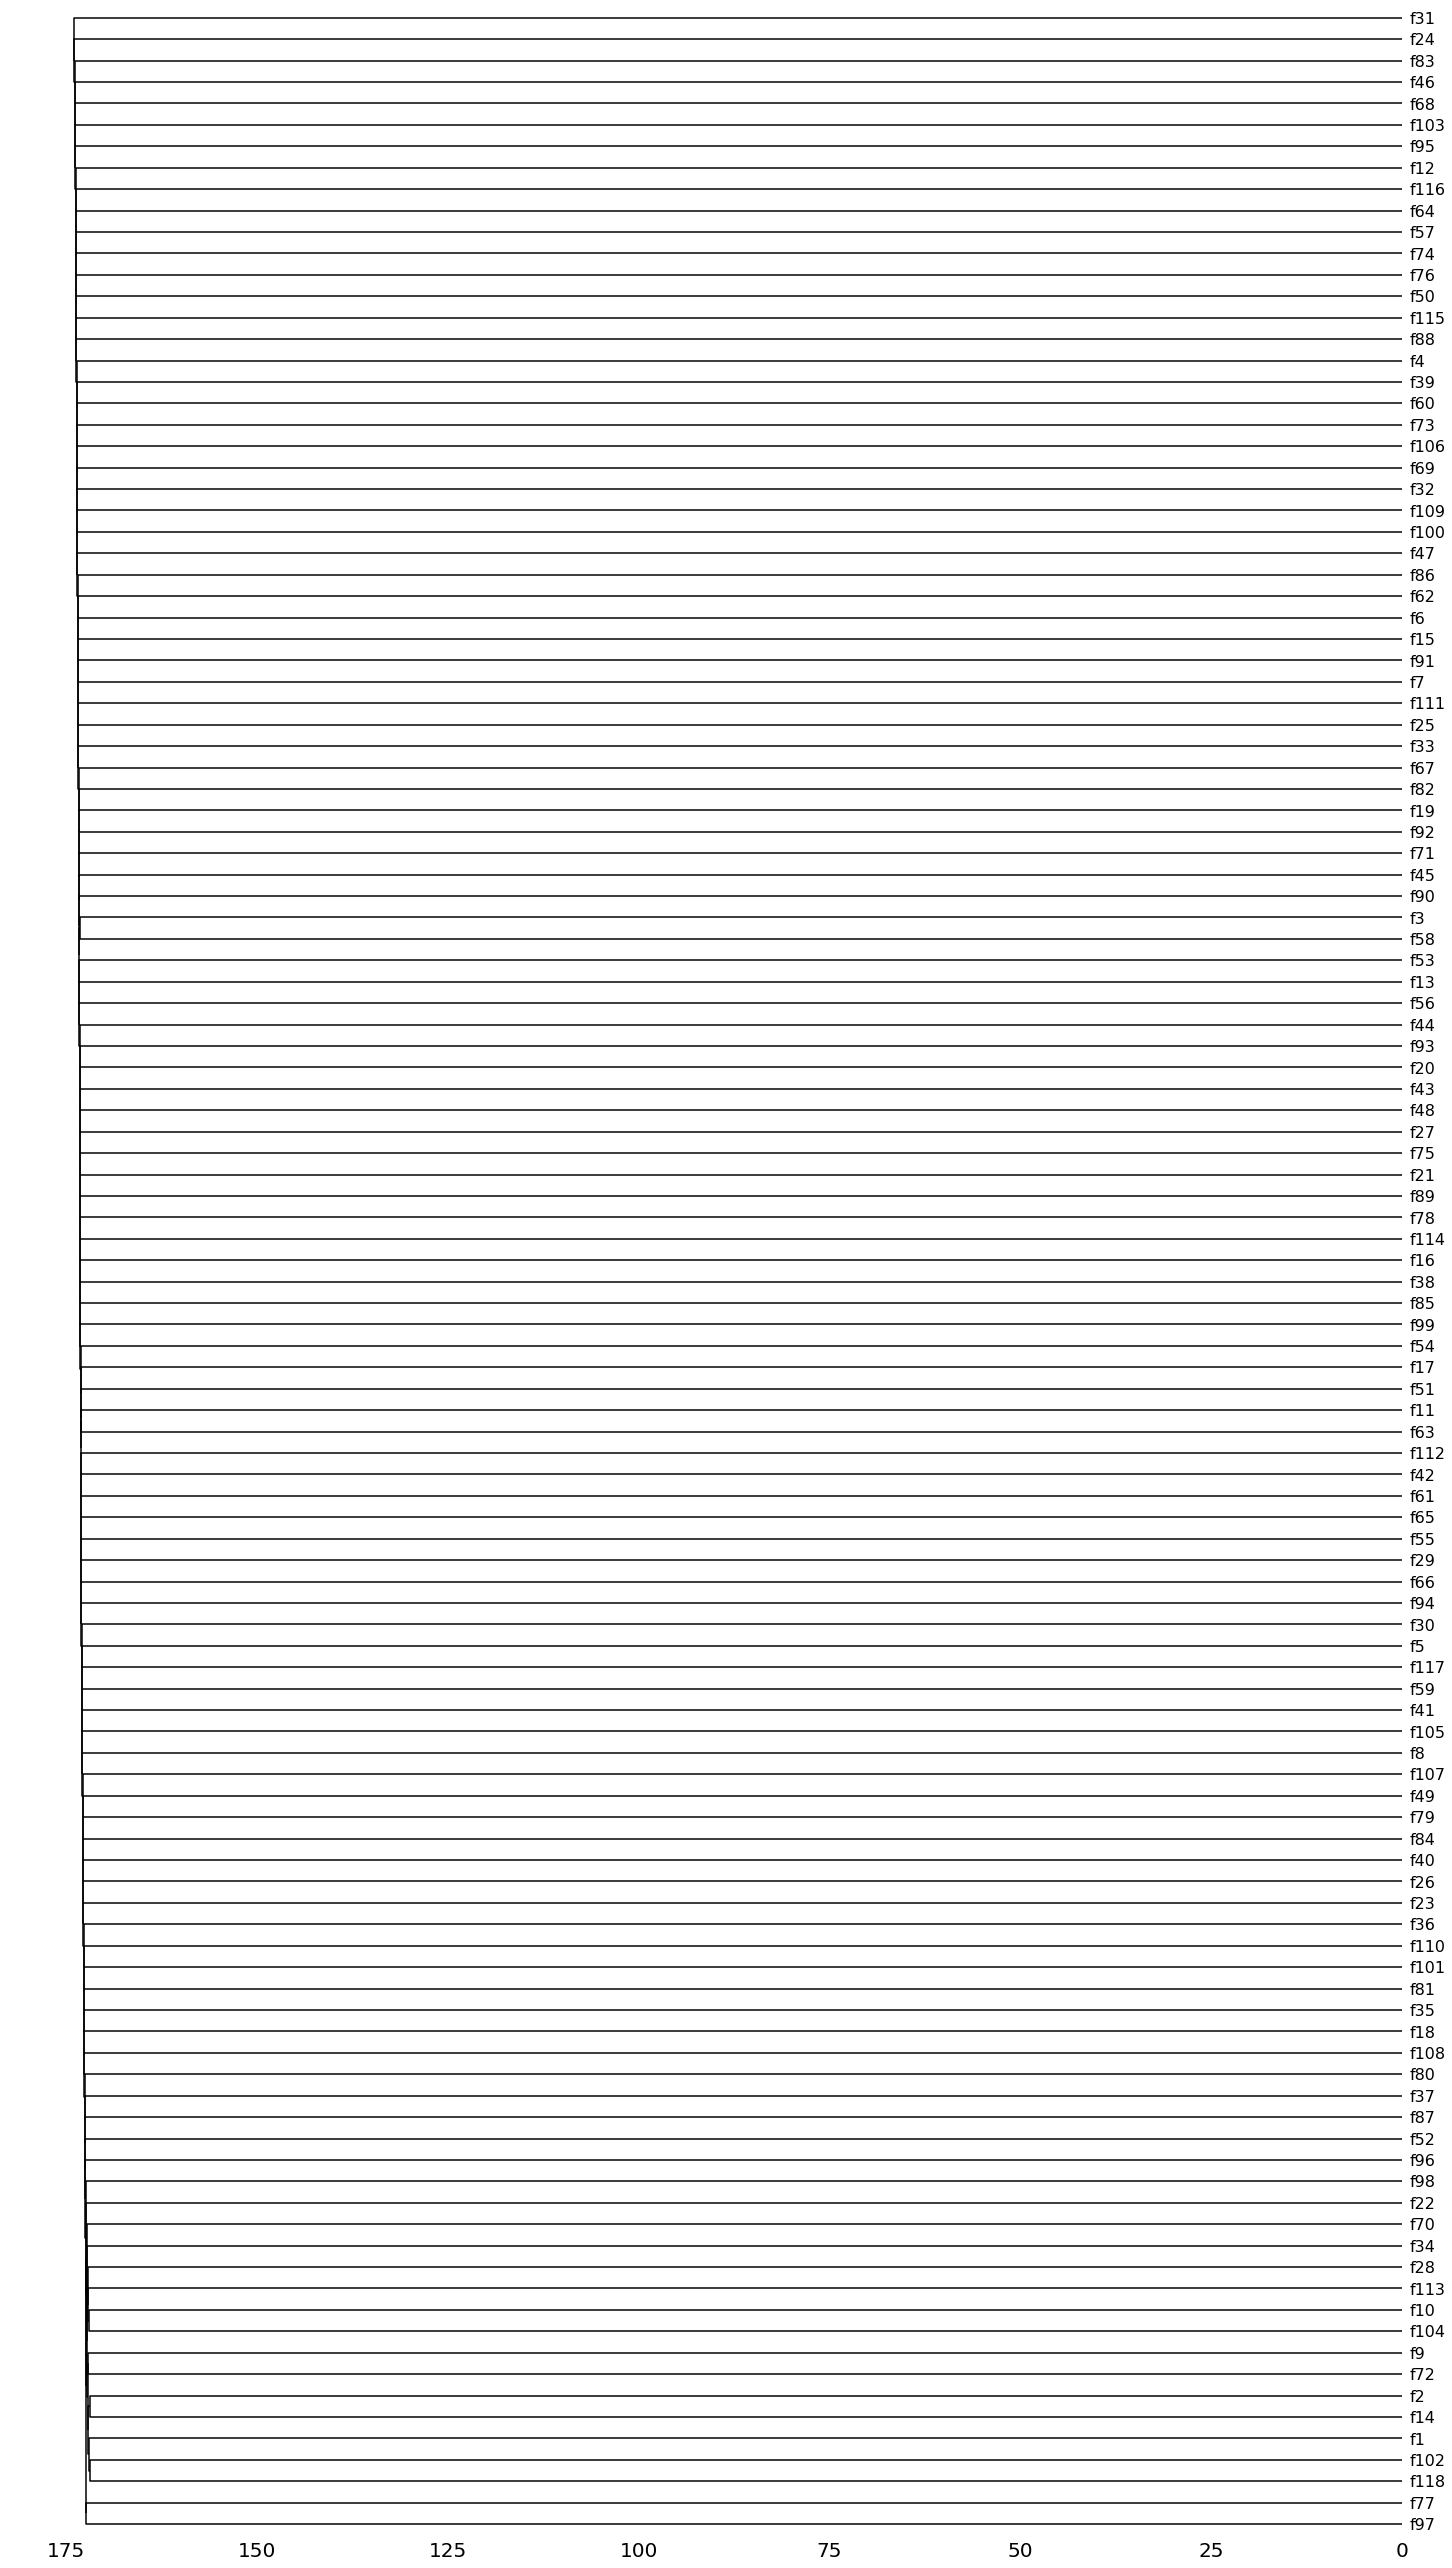

In [105]:
msno.dendrogram(X)

- Further demonstration that they're independent. So, I think we have an MCAR (missing completely at random) situation.